In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import torch
import torch.optim as optim
# TODO: add torch

In [2]:
toy_A = np.array([[3,2],[2,6]])
toy_b = np.array([[2],[-8]])

In [3]:
def steepest_descent(A, b, x0, max_iter=int(1e5), tol=1e-5, recompute=None):
    """
    Solving Ax = b or min(0.5xTAx - bTx + c)
    Steepest descent is at orthogonal to the previous one in each iteration.
    Suitable for scipy sparse and numpy dense arrays.
    Using fast iterative update of residual, rounding errors accumulates.

    A: dense or sparse matrix
    b, x0: column vectors
    recompute: number of iterations to recompute the exact residual, infered if not given

    returns:
        x: final x
        r: final residual
        num_iter: number of iterations run
    """
    if recompute is None:
        recompute = np.sqrt(A.shape[0])
    recompute = int(recompute)

    x = x0
    r = b - A@x
    delta = r.T@r
    tolerance = tol**2 * delta # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        q = A@r
        alpha = delta / (r.T@q)
        x = x + alpha *r
        if i % recompute == 0:
            r = b - A@x
        else:
            r = r - alpha*q
        delta = r.T@r

        if delta <= tolerance:
            num_iter = i+1
            break
    return x, r, num_iter

In [4]:
x0 = np.array([[-1],[-2]])
x, r, num = steepest_descent(toy_A, toy_b, x0, tol=1e-9)
print(num, " iterations taken to get result ", x.T, " with residual ", r.T)

30  iterations taken to get result  [[ 2. -2.]]  with residual  [[7.84016385e-09 5.22677546e-09]]


In [5]:
def CG(A, b, x0, max_iter=int(1e5), tol=1e-5, recompute=None):
    """
    Solving Ax = b or min(0.5xTAx - bTx + c)
    Conjugated gradient starts with the first descent direction as d0,
    The rest of the directions are all mutually A-orthogonal and can be built from d0,
    Thus, one direction only need to descend once
    Suitable for scipy sparse and numpy dense arrays.
    Using fast iterative update of residual, rounding errors accumulates.

    A: dense or sparse matrix
    b, x0: column vectors
    recompute: number of iterations to recompute the exact residual, infered if not given

    returns:
        x: final x
        r: final residual
        num_iter: number of iterations run
    """
    if recompute is None:
        recompute = np.sqrt(A.shape[0])
    recompute = int(recompute)

    x = x0
    r = b - A@x
    d = r
    delta_new = r.T@r
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        q = A@d
        alpha = delta_new / (d.T@q)
        x = x + alpha * d
        if i % recompute == 0:
            r = b - A@x
        else:
            r = r - alpha*q

        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        
        if delta_new <= tolerance:
            num_iter = i+1
            break
    return x, r, num_iter

In [6]:
x0 = np.array([[-1],[-2]])
x, r, num = CG(toy_A, toy_b, x0, tol=1e-9)
print(num, " iterations taken to get result ", x.T, " with residual ", r.T)

2  iterations taken to get result  [[ 2. -2.]]  with residual  [[0. 0.]]


In [7]:
# import torch
# import torch.optim as optim
# import matplotlib.pyplot as plt


# # 2d Rosenbrock function
# def f(x):
#     return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

 
# # Gradient descent
# x_gd = 10*torch.ones(2, 1)
# x_gd.requires_grad = True
# gd = optim.SGD([x_gd], lr=1e-5)
# history_gd = []
# for i in range(100):
#     gd.zero_grad()
#     objective = f(x_gd)
#     objective.backward()
#     gd.step()
#     history_gd.append(objective.item())


# # L-BFGS
# def closure():
#     lbfgs.zero_grad()
#     objective = f(x_lbfgs)
#     objective.backward()
#     return objective

# x_lbfgs = 10*torch.ones(2, 1)
# x_lbfgs.requires_grad = True

# lbfgs = optim.LBFGS([x_lbfgs],
#                     history_size=10, 
#                     max_iter=4, 
#                     line_search_fn="strong_wolfe")
                    
# history_lbfgs = []
# for i in range(100):
#     history_lbfgs.append(f(x_lbfgs).item())
#     lbfgs.step(closure)


# # Plotting
# plt.semilogy(history_gd, label='GD')
# plt.semilogy(history_lbfgs, label='L-BFGS')
# plt.legend()
# plt.show()

In [7]:
%load_ext autoreload
%autoreload 2
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
import functools
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt 

device = 'cuda'

from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error


def get_rendering(theta, update_fn=None, ctx_args=None): 
  return draw_rect(theta[0], theta[1])


def draw_rect(px, py):   
  s, w, h, exp = 256, 0.1, 0.1, 10
  ss = torch.linspace(0, 1, s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)


def render_smooth(perturbed_theta, update_fn, ctx_args):
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, ctx_args['gt_image'])
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)

      avg_img = torch.mean(torch.cat([x.unsqueeze(0) for x in imgs], dim=0), dim=0)
      loss = torch.stack(losses)
    print(loss.shape)
  return loss, avg_img

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 41)

In [3]:
def grad_torch(func, x, ctx, *args):
    '''
    x is a row vector with one extra dimension [[a, b, c, ...]]
    returns the gradient as a row vector with same shape as x
    '''
    y, _ = func(x, ctx)
    grad = torch.autograd.grad(y, x)[0]
    return grad

def grad_fd(func, x, ctx, epsilon=1e-6):
    '''
    To get gradient of a function using finite difference
    However, the smooth rendering function arleady has a forward pass that is the gradient instead of the actual function
    So we should treat the result of the func as the gradient, and not calculate its gradient again
    '''
    grad = torch.zeros_like(x)
    for i in range(x.size(0)):
        x_p = x.clone()
        x_n = x.clone()
        x_p[i] += epsilon
        x_n[i] -= epsilon
        y_p, _ = func(x_p, ctx)
        y_n, _ = func(x_n, ctx)
        grad[i] = (y_p - y_n) / 2 / epsilon
    return grad

def hessian_fd(func, x, ctx, grad_fn=grad_torch, epsilon=1e-4):
    '''
    x is a row vector with one extra dimension [[a, b, c, ...]]
    '''
    new_x = x.clone()
    new_x = new_x.view(1,-1) # ensures a row vector
    n = new_x.size(1)
    hessian_matrix = torch.zeros((n, n), device=device)
        
    for i in range(n):
        # Perturb the i-th element
        x_pi = new_x.clone()
        x_ni = new_x.clone()
        x_pi[0,i] += epsilon
        x_ni[0,i] -= epsilon
        # Compute the gradient vectors at the perturbed point
        # thess will be the column vector df/dx_(1~n) dx_i
        par_pi = grad_fn(func, x_pi, ctx, epsilon)
        par_ni = grad_fn(func, x_ni, ctx, epsilon)
        # Compute the second-order partial derivatives
        hessian_matrix[i] =  (par_pi - par_ni) / 2 / epsilon
    
    # hessian_matrix[1,1] = 0
    # hessian_matrix[0,1] = 0
    # hessian_matrix[1,0] = 0
    return hessian_matrix.T


def hessian_check(func, x, ctx, epsilon=1e-8):
    '''Check with tools'''
    def get_func_numpy(theta, *args):
        theta = torch.tensor(theta, device=device, dtype=torch.float32) 
        theta = theta.unsqueeze(0)
        result, _ = func(theta, *args)
        return result.cpu().detach().numpy()
    new_x = x.clone()
    x_num = new_x.clone().squeeze().cpu().detach().numpy() 
    Hfun = nd.Hessian(get_func_numpy, step=epsilon)
    hessian_nd = Hfun(x_num, ctx)
    return hessian_nd

In [4]:
#@title Set Algorithm Parameters { run: "auto", form-width: "25%", display-mode: "both" }
n_samples = 4 #@param {type:"slider", min:1, max:20, step:1}
sigma = 0.01 #@param {type:"slider", min:0.01, max:0.15, step:0.01}


hparams = {'nsamples': n_samples,
           'sigma': sigma,
           'learning_rate': 1e-3,
           'sigma_annealing': True,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'tol': 1e-5, # tolerance for CG
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-4, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'hessian_epsilon': 5e-4, # perturb size for hessian computation
           'diag_approx': False, # whether to use diagonal approximation in hessian calculation
           'plot_interval':100 # number of iterations to plot
           }

torch.manual_seed(0)
sigma = hparams['sigma']

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.66], requires_grad=True, device=device)
gt_theta = torch.tensor([0.5, 0.33], device=device)

# set up optim:
optim = torch.optim.Adam([theta], lr=hparams['learning_rate'])

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)

# set up ctx_args: 
ctx_args = {'antithetic': True, 'nsamples': hparams['nsamples'], 'sigma': hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}

/home/samuel/anaconda3/envs/prdpt/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Variance test

In [5]:
def lim_var_mean(data, threshold=1, axis=0):
    """
    Compute the variance along a specified axis while eliminating 'outliers'
    threshold (float): The number of standard deviations to use for outlier detection.
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std_dev = np.std(data, axis=axis, keepdims=True)
    
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    
    mask = (data >= lower_bound) & (data <= upper_bound)
    filtered_data = np.where(mask, data, np.nan)
    
    variances = np.nanvar(filtered_data, axis=axis)
    means = np.nanmean(filtered_data, axis=axis)
    
    return variances, means

In [9]:
# set up smoothed renderer
get_smoothed_loss = smoothFn(render_smooth,
                             context_args=None,
                             device=ctx_args['device'])

min_sample = 1
add_sample = 2
sigma = 0.01
sampler = 'importance'
x = torch.tensor([0.5, 0.4], requires_grad=True, device=device)
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 50
hess_fd_var = np.zeros((add_sample, 2, 2))
hess_fd_mean = np.zeros((add_sample, 2, 2))
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_var = np.zeros((2, add_sample))
grad_mean = np.zeros((2, add_sample))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    ctx_args = {'antithetic': True, 'nsamples': number_of_samples[i], 'sigma': 0.01,
                'sampler': sampler, 'device': device, 'gt_image': ref_img, 'update_fn': None}
    distribution_torch = np.zeros((n,2,2))
    distribution_conv = np.zeros((n,2,2))
    distribution_grad = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        distribution_conv[j,:,:] = smoothFn_hess(render_smooth, x.unsqueeze(0), context_args=ctx_args, device=ctx_args['device'], diag_approx=True).squeeze().cpu().detach().numpy()
        # hess_fd += hessian_fd(get_smoothed_loss, x.unsqueeze(0), ctx_args, grad_fn=grad_fd) # fd
        # hess_check += hessian_check(get_smoothed_loss, x.unsqueeze(0), ctx_args) # numdifftools
        distribution_torch[j,:,:] = hessian_fd(get_smoothed_loss, x.unsqueeze(0), ctx_args, grad_fn=grad_torch).squeeze().cpu().detach().numpy() # pytorch
        grad = grad_torch(get_smoothed_loss, x.unsqueeze(0), ctx_args)
        grad = grad.squeeze().cpu().detach().numpy()
        distribution_grad[:, j] = grad
    
    print("Time taken: ", time.time()-start_time)

    # clamp_00 = np.clip(distribution_torch[:, 0,0], -2, 2)
    # clamp_11 = np.clip(distribution_torch[:, 1,1], -2, 2)
    # plt.subplot(1,2,1)
    # plt.hist(clamp_00, bins=100)
    # plt.tight_layout()
    # plt.title("Finite difference Hessian 00")
    # plt.subplot(1,2,2)
    # plt.hist(clamp_11, bins=100)
    # plt.tight_layout()
    # plt.title("Finite difference Hessian 11")
    # plt.show()
    # clamp_00 = np.clip(distribution_conv[:, 0,0], -2, 2)
    # clamp_11 = np.clip(distribution_conv[:, 1,1], -2, 2)
    # plt.subplot(1,2,1)
    # plt.hist(clamp_00, bins=100)
    # plt.tight_layout()
    # plt.xlim(-1.9,1.9)
    # plt.title("Convolved Hessian 00")
    # plt.subplot(1,2,2)
    # plt.hist(clamp_11,bins=100)
    # plt.tight_layout()
    # plt.xlim(-1.9,1.9)
    # plt.title("Convolved Hessian 11")
    # plt.show()
    hess_fd_var[i, :, :] = np.var(distribution_torch, axis=0)
    grad_var[:, i] = np.var(distribution_grad, axis=1)
    hess_fd_mean[i, :, :] = np.mean(distribution_torch, axis=0)
    grad_mean[:, i] = np.mean(distribution_grad, axis=1)
    hess_conv_var[i, :, :] = np.var(distribution_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(distribution_conv, axis=0)
    # hess_fd_var[i, :, :], hess_fd_mean[i, :, :] = lim_var_mean(distribution_torch, threshold=1, axis=0)
    # grad_var[:, i], grad_mean[:, i] = lim_var_mean(distribution_grad, threshold=3, axis=1)
    # hess_conv_var[i, :, :], hess_conv_mean[i, :, :] = lim_var_mean(distribution_conv, threshold=1, axis=0)


Number of samples:  1
Time taken:  8.601516008377075
Number of samples:  2


KeyboardInterrupt: 

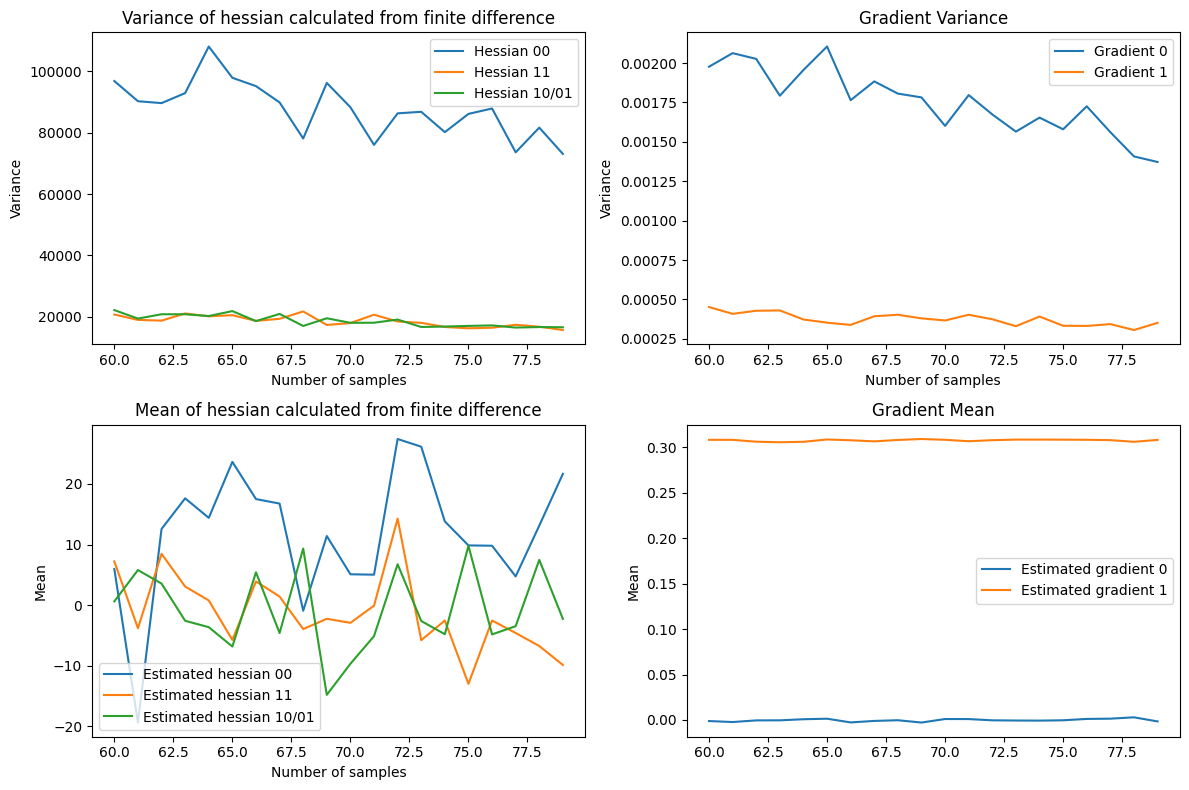

In [69]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_fd_var[:,0,0], label="Hessian 00")
plt.plot(number_of_samples, hess_fd_var[:,1,1], label="Hessian 11")
plt.plot(number_of_samples, hess_fd_var[:,1,0], label="Hessian 10/01")
plt.title("Variance of hessian calculated from finite difference")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var[0,:], label="Gradient 0")
plt.plot(number_of_samples, grad_var[1,:], label="Gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_fd_mean[:,0,0], label="Estimated hessian 00")
plt.plot(number_of_samples, hess_fd_mean[:,1,1], label="Estimated hessian 11")
plt.plot(number_of_samples, hess_fd_mean[:,1,0], label="Estimated hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of hessian calculated from finite difference")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean[0,:], label="Estimated gradient 0")
plt.plot(number_of_samples, grad_mean[1,:], label="Estimated gradient 1")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()



In [19]:
num = 10
distribution = np.zeros((2, num))

for i in range(num):
    grad = grad_torch(get_smoothed_loss, x.unsqueeze(0), ctx_args)
    grad = grad.squeeze().cpu().detach().numpy()
    distribution[:, i] = grad

[0.21914256 0.21914262]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[-0.17473757  0.17473751]
[[0.21914256 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.21914262 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]
[0.60474217 0.60474217]
[[ 0.21914256 -0.17473757  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.21914262  0.17473751  0.          0.          0.          0.
   0.          0.          0.          0.        ]]
[0.40715116 0.40715122]
[[ 0.21914256 -0.17473757  0.60474217  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.21914262  0.17473751  0.60474217  0.          0.          0.
   0.          0.          0.          0.        ]]
[0.4377281  0.43772817]
[[ 0.21914256 -0.17473757  0.60474217  0.40715116  0.          0.
   0.          0.          0.          0.        ]
 [ 0.2191

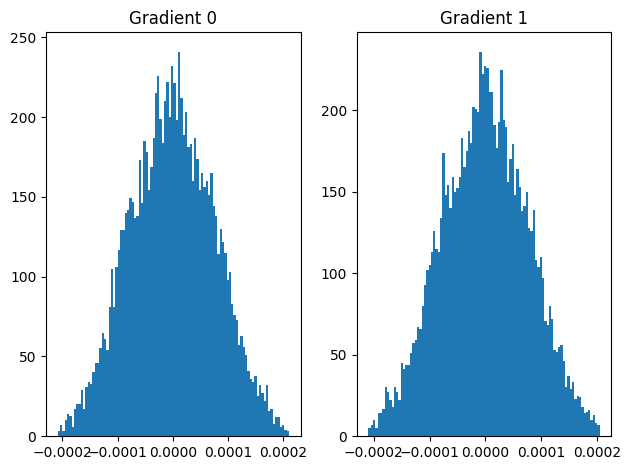

In [215]:
distribution[1, np.argmin(distribution[1])] = 0
plt.subplot(1,2,1)
plt.hist(distribution[0], bins=100)
plt.tight_layout()
plt.title("Gradient 0")
plt.subplot(1,2,2)
plt.hist(distribution[1],bins=100)
plt.tight_layout()
plt.title("Gradient 1")
plt.show()


In [324]:
def NCG(f, x0, max_iter, diff, hess, **f_args):
    """
    Non-linear CG for minimizing the SmoothFn.
    x0: initial guess as a row vector
    """
    tol = f_args['opt_args']['tol']
    NR_max_iter = f_args['opt_args']['NR_max_iter']
    NR_tol = f_args['opt_args']['NR_tol']
    recompute = f_args['opt_args']['recompute']
    hessian_epsilon = f_args['opt_args']['hessian_epsilon']
    interval = f_args['opt_args']['plot_interval']
    diag_approx = f_args['opt_args']['diag_approx']
    grad_fn = f_args['opt_args']['grad_fn']
    rate = f_args['opt_args']['learning_rate']
    
    ctx_args = f_args['ctx_args']
    hparams = f_args['opt_args']
    img_errors, param_errors = [], []
    x = x0.unsqueeze(0)
    k = 0
    r = -diff(f, x, ctx_args).T # r should be column vector
    d = r
    delta_new = (r.T@r).item()
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        delta_d = d.T@d
        for j in range(NR_max_iter): # newton-ralph approximation
            hessian = hess(f, x, ctx_args, grad_fn=grad_fn, epsilon=hessian_epsilon) if not diag_approx else torch.diag(hess(f, x, ctx_args, grad_fn=grad_fn, epsilon=hessian_epsilon).diag())
            # hessian = smoothFn_hess(render_smooth, x, context_args=ctx_args, device=ctx_args['device'], diag_approx=diag_approx)/250
            hessian = hessian * rate

            denom = d.T@hessian@d
            if i == 0:
                assert denom != 0, "try a new starting point"
            elif denom == 0:
                d = r = -diff(f, x, ctx_args).T
                x=x0.unsqueeze(0)
                break
            alpha = -(diff(f, x, ctx_args)@d / denom).item()
            x = x + alpha*d.squeeze()
            if alpha**2 * delta_d <= NR_tol:
                break
        r = -diff(f, x, ctx_args).T
        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        if k>=recompute or r.T@d <=0: # restart whenever a search direction is computed that is not descent direction
            k = 0
            d = r
        # if param_errors and param_errors[-1] < 0.03:
        #     hessian_epsilon = 8e-4
        if delta_new <= tolerance:
            num_iter = i+1
            print("Converged at ", i+1)
            img_errors, param_errors = logging(x, img_errors, param_errors, i=interval-1, interval=interval)
            break
        img_errors, param_errors = logging(x, img_errors, param_errors, i, interval=interval)
        # ctx_args = sigma_scheduler(i, hparams, ctx_args)
    return x, r, num_iter

def logging(theta, img_errors, param_errors, i, interval=5):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    print(f"Iter {i+1}/{hparams['epochs']} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

def sigma_scheduler(iter, hparams, ctx_args):
    if iter > hparams['anneal_const_first'] and hparams['sigma_annealing'] and ctx_args['sigma'] >= hparams['anneal_sigma_min']:
        sigma = run_scheduler_step(sigma, curr_iter=i+1, sigma_initial=hparams['sigma'], sigma_min=hparams['anneal_sigma_min'], 
                                   n=hparams['epochs'], const_first_n=hparams['anneal_const_first'], const_last_n=hparams['anneal_const_last'])
        ctx_args['sigma'] = sigma
    return ctx_args

#### Variance test

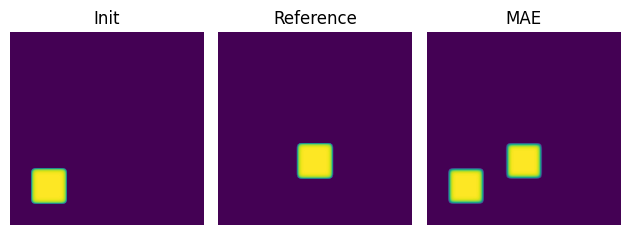

Iter 1/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 2/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 3/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 4/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 5/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 6/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 7/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 8/500 - Img.Loss: 0.0516 - Param.Loss: 0.0535
Iter 9/500 - Img.Loss: 0.0516 - Param.Loss: 0.0534
Iter 10/500 - Img.Loss: 0.0516 - Param.Loss: 0.0530
Iter 11/500 - Img.Loss: 0.0516 - Param.Loss: 0.0534
Iter 12/500 - Img.Loss: 0.0516 - Param.Loss: 0.0536
Iter 13/500 - Img.Loss: 0.0516 - Param.Loss: 0.0529
Iter 14/500 - Img.Loss: 0.0516 - Param.Loss: 0.0506
Iter 15/500 - Img.Loss: 0.0516 - Param.Loss: 0.0503
Iter 16/500 - Img.Loss: 0.0516 - Param.Loss: 0.0497
Iter 17/500 - Img.Loss: 0.0516 - Param.Loss: 0.0495
Iter 18/500 - Img.Loss: 0.0516 - Param.Loss: 0.0527
Iter 19/500 - Img.Loss: 0.0516 - Param.Loss: 0.0525
Iter 20/500 - Img.Los

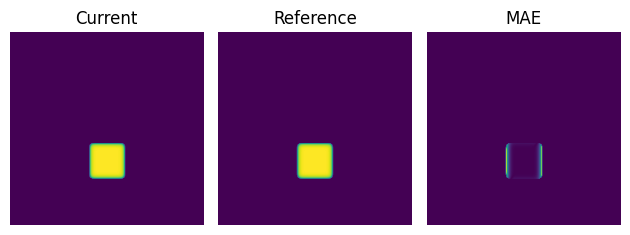

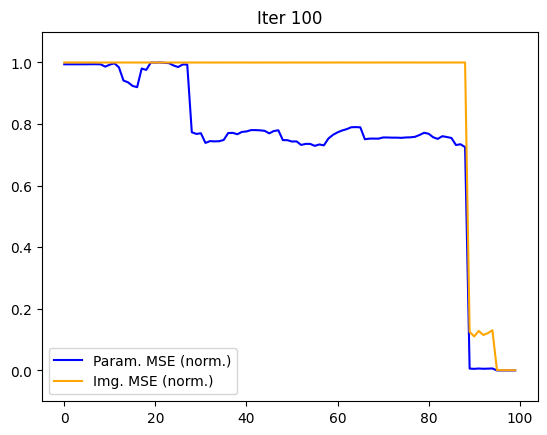

Iter 101/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 102/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 103/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 104/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 105/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 106/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 107/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 108/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 109/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 110/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 111/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 112/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 113/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 114/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 115/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 116/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 117/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 118/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 119/500 - Img.Loss: 0.0000 - Param.Loss: 

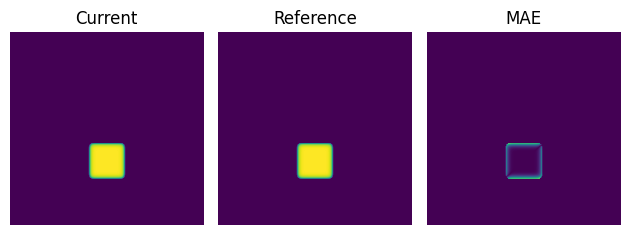

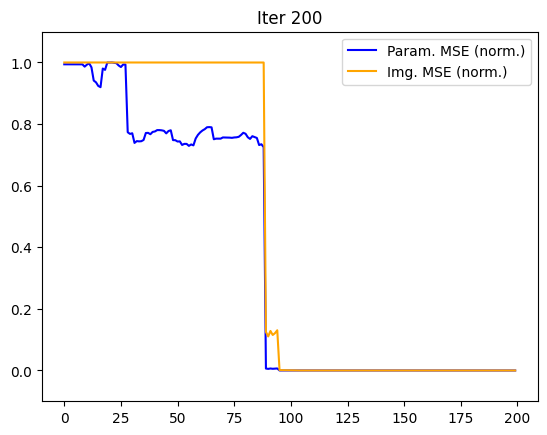

Iter 201/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 202/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 203/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 204/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 205/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 206/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 207/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 208/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 209/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 210/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 211/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 212/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 213/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 214/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 215/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 216/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 217/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 218/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 219/500 - Img.Loss: 0.0000 - Param.Loss: 

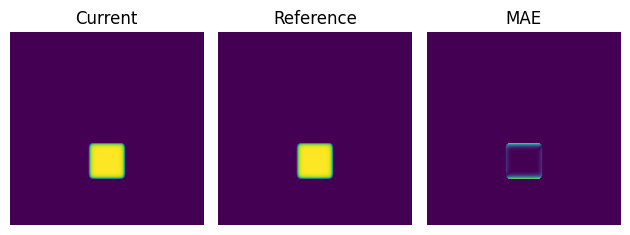

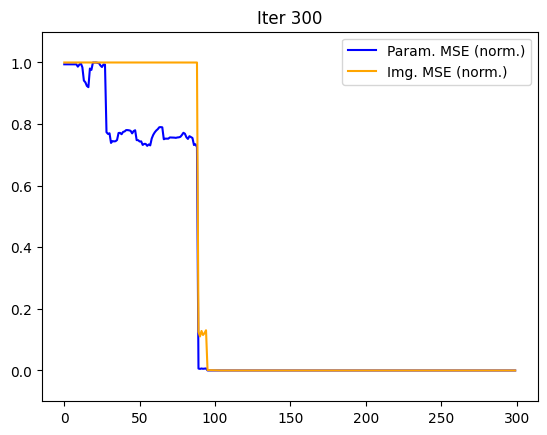

Iter 301/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 302/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 303/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 304/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 305/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 306/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 307/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 308/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 309/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 310/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 311/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 312/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 313/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 314/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 315/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 316/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 317/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 318/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 319/500 - Img.Loss: 0.0000 - Param.Loss: 

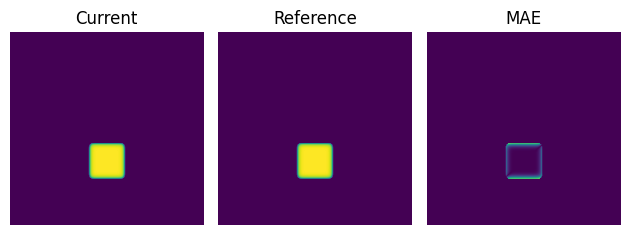

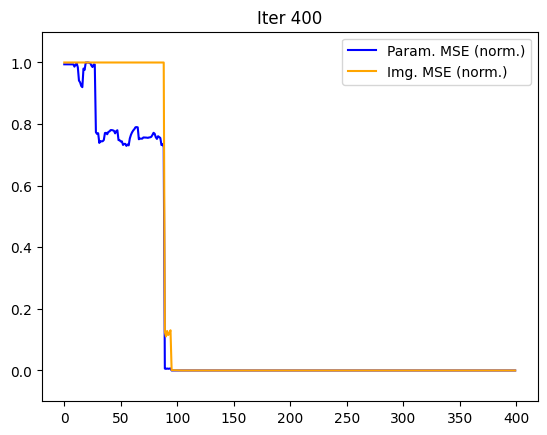

Iter 401/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 402/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 403/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 404/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 405/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 406/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 407/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 408/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 409/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 410/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 411/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 412/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 413/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 414/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 415/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 416/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 417/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 418/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 419/500 - Img.Loss: 0.0000 - Param.Loss: 

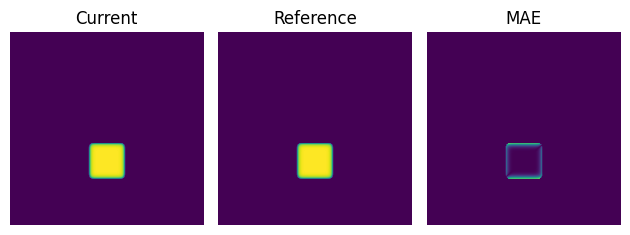

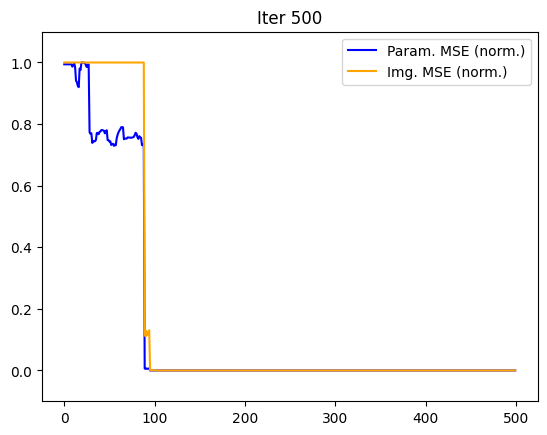

(tensor([[0.5000, 0.3300]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 3.9279e-05],
         [-3.9279e-05]], device='cuda:0'),
 500)

In [388]:

# plt.rcParams['figure.figsize'] = (12, 6)
hparams = {'nsamples': 4,
           'sigma': sigma,
           'learning_rate': 1,
           'sigma_annealing': True,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'tol': 1e-3, # tolerance for CG
           'grad_fn': grad_torch, # the function to compute gradient
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-5, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'hessian_epsilon': 9e-4, # perturb size for hessian computation
           'diag_approx': False, # whether to use diagonal approximation in hessian calculation
           'plot_interval':100 # number of iterations to plot
           }
# set up smoothed renderer
get_smoothed_loss = smoothFn(render_smooth,
                             context_args=None,
                             device=ctx_args['device'])

# --------------- run optimization
max_iter = hparams['epochs']
theta = torch.tensor([0.2, 0.2], requires_grad=True, device=device)
init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)
show_with_error(init_img, ref_img, iter=0)
x = theta.requires_grad_(True)
NCG(get_smoothed_loss, x, max_iter, grad_torch, hessian_fd, opt_args=hparams, ctx_args=ctx_args)

    # sigma scheduling:
    # if i > hparams['anneal_const_first'] and hparams['sigma_annealing'] and sigma >= hparams['anneal_sigma_min']:
    #     sigma = run_scheduler_step(sigma, curr_iter=i+1, sigma_initial=hparams['sigma'], sigma_min=hparams['anneal_sigma_min'], 
    #                                n=hparams['epochs'], const_first_n=hparams['anneal_const_first'], const_last_n=hparams['anneal_const_last'])
    #     ctx_args['sigma'] = sigma